In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2 as cv

from skimage.feature import SIFT, match_descriptors
from skimage.color import rgb2gray

# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.utils import to_categorical
# from tensorflow.keras.preprocessing.image import load_img, img_to_array
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


In [2]:
# Load the image paths and labels from the DataFrame
df = pd.read_csv('Dataset/cards.csv')

# For column names that contain space, replace the space with an underscore
df.columns = [c.replace(' ', '_') for c in df.columns]

# Add suits column
df['suit'] = df['labels'].str.split().str[-1]

# Remove rows with jokers
df = df[~df['suit'].str.contains('joker', case=False)]

# Remove unwanted columns
df = df.drop(columns = ['data_set'])
df = df.drop(columns = ['class_index'])
df = df.drop(columns = ['labels'])
df = df.drop(columns = ['card_type'])

# Add folder name to the filepath
df['filepaths'] = df['filepaths'].apply(lambda x: 'Dataset/' + x)
df.head()

,filepaths,suit
0,Dataset/train/ace of clubs/001.jpg,clubs
1,Dataset/train/ace of clubs/002.jpg,clubs
2,Dataset/train/ace of clubs/003.jpg,clubs
3,Dataset/train/ace of clubs/004.jpg,clubs
4,Dataset/train/ace of clubs/005.jpg,clubs


In [3]:
# Split dataframe into train and test sets, stratified by the 'suit' column
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['suit'], random_state=42)

# Split train set into train and validation sets, stratified by the 'suit' column
train_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df['suit'], random_state=42)

# Check class distribution in the train, validation, and test sets
train_class_distribution = train_df['suit'].value_counts(normalize=True)
val_class_distribution = val_df['suit'].value_counts(normalize=True)
test_class_distribution = test_df['suit'].value_counts(normalize=True)

In [4]:
train_df = train_df.reset_index(drop = True)
val_df = val_df.reset_index(drop = True)

In [7]:
def detect_and_extract_keypoints(dataframe):
    detector_and_extractor = SIFT(upsampling=2, 
                              n_octaves=10, 
                              n_scales=10, 
                              sigma_min=1.8, 
                              sigma_in=0.5, 
                              c_dog=0.01, 
                              c_edge=30, 
                              n_bins=36, 
                              lambda_ori=1.5, 
                              c_max=0.8, 
                              lambda_descr=6, 
                              n_hist=4, 
                              n_ori=8
                             )
    keypoint_images = []
    keypoint_labels = []
    keypoint_descript = []
    keypoint_feat = []
    keypoint_pixels = []

    for i in range(len(dataframe)):
        rgb_test_image = cv.imread(dataframe['filepaths'][i])
        gray_test_image = rgb2gray(rgb_test_image)
        normalised_image = cv.normalize(gray_test_image, 
                                            None, 
                                            alpha=0, 
                                            beta=1, 
                                            norm_type=cv.NORM_MINMAX
                                           )

        detector_and_extractor.detect_and_extract(normalised_image)
        keypoint_features = detector_and_extractor.keypoints
        keypoint_descriptors = detector_and_extractor.descriptors

        if len(keypoint_features) > 0:
            keypoint_feature_image = np.zeros(gray_test_image.shape)
            key_pixels = []

            for point in keypoint_features:
                keypoint_feature_image[point[0], point[1]] = gray_test_image[point[0], point[1]]
                key_pixel = gray_test_image[point[0], point[1]]
                key_pixels.append(key_pixel)
            
            if i % 100 == 0:
                print(i)
            keypoint_pixels.append(key_pixels)
            keypoint_images.append(keypoint_feature_image)
            keypoint_labels.append(dataframe['suit'][i])
            keypoint_descript.append(keypoint_descriptors)
            keypoint_feat.append(keypoint_features)
    
    return keypoint_images, keypoint_labels, keypoint_descript, keypoint_feat, keypoint_pixels


In [8]:
# def detect_and_extract_keypoints(dataframe):
#     detector_and_extractor = SIFT(upsampling=2, 
#                               n_octaves=10, 
#                               n_scales=10, 
#                               sigma_min=1.8, 
#                               sigma_in=0.5, 
#                               c_dog=0.01, 
#                               c_edge=30, 
#                               n_bins=36, 
#                               lambda_ori=1.5, 
#                               c_max=0.8, 
#                               lambda_descr=6, 
#                               n_hist=4, 
#                               n_ori=8
#                              )
#     keypoint_images = []
#     keypoint_labels = []
#     keypoint_descript = []
#     keypoint_feat = []
#     keypoint_pixels = []

#     for i in range(len(dataframe)):
#         rgb_test_image = cv.imread(dataframe['filepaths'][i])
#         gray_test_image = rgb2gray(rgb_test_image)

#         detector_and_extractor.detect_and_extract(gray_test_image)
#         keypoint_features = detector_and_extractor.keypoints
#         keypoint_descriptors = detector_and_extractor.descriptors

#         if len(keypoint_features) > 0:
#             keypoint_feature_image = np.zeros(gray_test_image.shape)
#             key_pixels = []

#             for point in keypoint_features:
#                 keypoint_feature_image[point[0], point[1]] = gray_test_image[point[0], point[1]]
#                 key_pixel = gray_test_image[point[0], point[1]]
#                 key_pixels.append(key_pixel)
                
#             normalised_image = cv.normalize(keypoint_feature_image, 
#                                             None, 
#                                             alpha=0, 
#                                             beta=1, 
#                                             norm_type=cv.NORM_MINMAX
#                                            )
            
#             if i % 1000 == 0:
#                 print(i)
#             keypoint_pixels.append(key_pixels)
#             keypoint_images.append(normalised_image)
#             keypoint_labels.append(dataframe['suit'][i])
#             keypoint_descript.append(keypoint_descriptors)
#             keypoint_feat.append(keypoint_features)
    
#     return keypoint_images, keypoint_labels, keypoint_descript, keypoint_feat, keypoint_pixels


In [9]:
train_image, train_labels, train_descriptors, train_features, train_keypixels = detect_and_extract_keypoints(train_df)
val_image, val_labels, val_descriptors, val_features, val_keypixels = detect_and_extract_keypoints(val_df)


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
0
100
200
300
400
500
600
700
800
900
1000
1100
1200


In [10]:
print(f'train image and label vector length: {len(train_labels)}, {len(train_image)}')
print(f'validation image and label vector length: {len(val_labels)}, {len(val_image)}')

train image and label vector length: 5138, 5138
validation image and label vector length: 1285, 1285


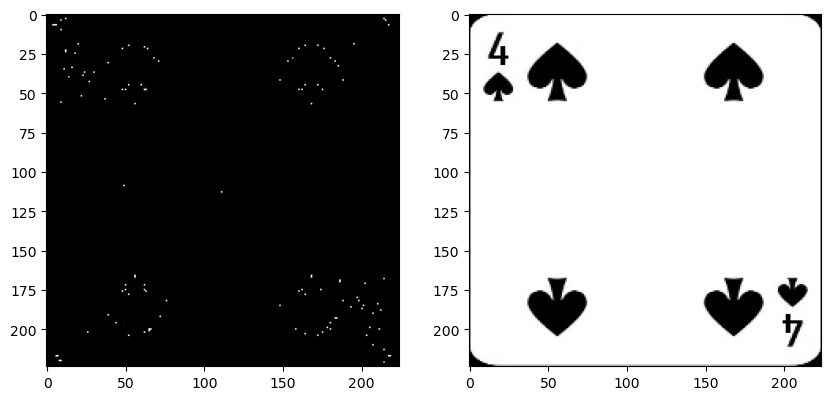

In [11]:
#display the feature vectors and compare to the original image
train_image_test = cv.imread(train_df['filepaths'][0])
figs, axes = plt.subplots(1,2, figsize=(10,5))
axes[0].imshow(train_image[0], cmap = 'gray')
axes[1].imshow(train_image_test, cmap = 'gray')

In [14]:
len_feat_vec = [len(feature) for feature in train_features]
min_feat_len = np.min(len_feat_vec)

X_train_feat_ = np.array([feat_vec[:min_feat_len] for feat_vec in train_keypixels])
X_train_descript = np.array([feat_vec[:min_feat_len] for feat_vec in train_descriptors])

X_val_feat = np.array([feat_vec[:min_feat_len] for feat_vec in val_keypixels])
X_val_descript = np.array([feat_vec[:min_feat_len] for feat_vec in val_descriptors])


In [15]:
#encode the labels
def encode_labels(labels):
    label_encoder = preprocessing.LabelEncoder()
    keypoint_labels_encoded = label_encoder.fit(labels)
    encoded_labels_transformed = label_encoder.transform(labels)
    return encoded_labels_transformed

encoded_train_labels = encode_labels(train_labels)
encoded_val_labels = encode_labels(val_labels)


In [16]:
#flattening images
def flatten_images(image_dataset):
    flattened_images = []

    for image in image_dataset:
        flat_image = np.ravel(image)
        flattened_images.append(flat_image)
        
    return np.array(flattened_images)

flat_train_descript = flatten_images(X_train_descript)
flat_val_descript = flatten_images(X_val_descript)

flattened_train_images = np.hstack((flat_train_descript, X_train_feat_))
flattened_validation_images = np.hstack((flat_val_descript, X_val_feat))



# SVM Classification on Keypoint Features and Detectors

In [17]:
#SVM Classification

def svm_classifier(X_train, Y_train, x_val, y_val, kernel_val, C_float):
    
    svm_classifier = Pipeline([
        ('standardscaler', StandardScaler()),
        ('svc', svm.SVC(gamma='auto', kernel = kernel_val, C = C_float))
    ])

    svm_classifier.fit(X_train, Y_train)
    
    #calculating the average accuracy
    val_score = svm_classifier.score(x_val, y_val)
    
    #predicting labels of validation data
    val_predict = svm_classifier.predict(x_val)
    
    #generating the confusion matrix
    val_confusion_matrix = confusion_matrix(y_val, val_predict)

    #displaying the confustion matrix
    display_matrix = ConfusionMatrixDisplay(confusion_matrix = val_confusion_matrix,
                                              display_labels = svm_classifier.classes_)
    
    return val_score, display_matrix


0.5159533073929962


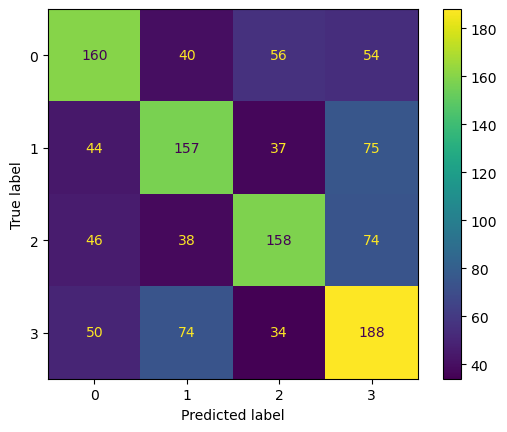

In [20]:
#svm parameters c = 1, gamma = auto, kernel = rbf
val_score_1, display_matrix_1 = svm_classifier(flattened_train_images, 
               encoded_train_labels, 
               flattened_validation_images, 
               encoded_val_labels, 
               'rbf', 
               4)

print(val_score_1)
display_matrix_1.plot()

# Linear Discriminant Analysis on Keyppoint Features and Descriptors

In [21]:
lda_classifier_svd = LinearDiscriminantAnalysis(solver = 'svd')
lda_classifier_svd.fit(flattened_train_images, encoded_train_labels)

#Evaluate the results
lda_svd = lda_classifier_svd.score(flattened_validation_images, encoded_val_labels)
print(f'Average accuracy: {lda_svd}')

Average accuracy: 0.3603112840466926
